In [14]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import function_library_assignment_1 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #filtering FutureWarnings - we don't need to worry about them in this case
#(This is run using Python 3.9)

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading data

In [22]:
S_base_3ph = 100
gen_data = fnc.read_data('gen_data')
demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_costs = fnc.read_data('gen_costs')
line_data = fnc.read_data('line_data')
branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data')

GC = len(gen_data.index)
GW = len(wind_data.columns)
G = GC + GW
D = len(load_distribution.index)
N = 24 # number of buses

WF_NODES = [2, 4, 6, 15, 20, 22] #zero-indexed

Set up demand array for the hour

In [19]:
t = 0 #hour
load = np.zeros(N)

#Saving the load for each bus in a numpy array accounting for the system load destribution
for n in load_distribution['Node'].unique():
    load[n-1] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * demand[t] #per-unitized load - remember that the data is not 0-indexed but the arrays are

load

array([ 67.48173 ,  60.37839 , 111.877605,  46.17171 ,  44.395875,
        85.24008 ,  78.13674 , 106.5501  , 108.325935, 120.75678 ,
         0.      ,   0.      , 165.152655, 120.75678 , 197.117685,
        62.154225,   0.      , 207.772695, 113.65344 ,  79.912575,
         0.      ,   0.      ,   0.      ,   0.      ])

Setup bid prices for loads

In [27]:
#TEMP
bid_prices = np.ones(D) * 25

array([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25.])

## Setup Gurobi model

In [28]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
p_G = m.addVars(G, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: wind farms can be curtailed AND P_min from the system should be disregarded to avoid having a mixed integer program
p_D = m.addVars(D, lb=0, ub=gb.GRB.INFINITY, name="P_D") #Note: demands are elastic

#============= Objective function =============
# Set objective function (social welfare) - note that production cost of wind farms is assumed to be zero
obj = gb.quicksum(bid_prices[d] * p_D[d] for d in range(D)) - gb.quicksum(gen_costs['C (DKK/MWh)'][k] * p_G[k] for k in range(GC))
m.setObjective(obj, direction)

#============= Balance equation =============
m.addConstr(gb.quicksum(p_G[g] for g in range(G)) - gb.quicksum(p_D[d] for d in range(D)) == 0)

#============= Generator limits =============
m.addConstrs(p_G[g] <= (gen_data['P max MW'].iloc[g]) for g in range(GC)) #conventinal generator upper limits

#Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_G[GC + g] <= wind_data.iloc[t, g] for g in range(GW)) #wind farm generator upper limits

#============= Demand limits =============
m.addConstrs(p_D[d] <= load[d] for d in range(D)) #demand limits

#============= Display and run model =============
m.update()
m.display()
m.optimize()

Maximize
-93.6396 P_G[0] + -93.6396 P_G[1] + -145.521 P_G[2] + -147.1379 P_G[3] +
-183.5533 P_G[4] + -73.9556 P_G[5] + -73.9556 P_G[6] + -42.3206 P_G[7] + -38.4541 P_G[8]
+ -73.9556 P_G[10] + -76.5567 P_G[11] + 25.0 P_D[0] + 25.0 P_D[1] + 25.0 P_D[2]
+ 25.0 P_D[3] + 25.0 P_D[4] + 25.0 P_D[5] + 25.0 P_D[6] + 25.0 P_D[7] + 25.0 P_D[8]
+ 25.0 P_D[9] + 25.0 P_D[10] + 25.0 P_D[11] + 25.0 P_D[12] + 25.0 P_D[13] + 25.0 P_D[14]
+ 25.0 P_D[15] + 25.0 P_D[16]
Subject To
R0: P_G[0] + P_G[1] + P_G[2] + P_G[3] + P_G[4] + P_G[5] + P_G[6] + P_G[7] + P_G[8] +
P_G[9] + P_G[10] + P_G[11] + P_G[12] + P_G[13] + P_G[14] + P_G[15] + P_G[16] + P_G[17] +
-1.0 P_D[0] + -1.0 P_D[1] + -1.0 P_D[2] + -1.0 P_D[3] + -1.0 P_D[4] + -1.0 P_D[5] + -1.0
P_D[6] + -1.0 P_D[7] + -1.0 P_D[8] + -1.0 P_D[9] + -1.0 P_D[10] + -1.0 P_D[11] + -1.0
 P_D[12] + -1.0 P_D[13] + -1.0 P_D[14] + -1.0 P_D[15] + -1.0 P_D[16] = 0
  R1: P_G[0] <= 152
  R2: P_G[1] <= 152
  R3: P_G[2] <= 350
  R4: P_G[3] <= 591
  R5: P_G[4] <= 60
  R6: P_G[5] <

## Analyze results

In [36]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {}
    generator_outputs = pd.DataFrame(data=np.zeros(G), columns=['p_G'])
    generator_outputs['Node'] = 0 #initialize
    generator_outputs['Dispatched Percentage'] = 0
    generator_outputs['Type'] = 'Conventional'

    load_results = pd.DataFrame(data=np.zeros(D), columns=['p_D'])
    load_results['Node'] = load_distribution['Node'].values
    load_results['Maximum Demand'] = load[load != 0]

    constraints = m.getConstrs()
    # The constraint dual value of the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f DKK" % m.objVal)

    for i in range(G):
        print(p_G[i].VarName + ": %.2f pu" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x

        if i < GC:
            generator_outputs.loc[generator_outputs.index == i, 'Node'] = gen_data.loc[gen_data.index == i, 'Node'].values #save node
            gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
            generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i].x / gen_limit) * 100
        else:
            generator_outputs.loc[generator_outputs.index == i, 'Node'] = WF_NODES[i - GC] + 1 #save node (from zero-indexed to 1-indexed)
            wind_limit = wind_data.iloc[t, i - GC]
            generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i].x / wind_limit) * 100
            generator_outputs.loc[generator_outputs.index == i, 'Type'] = 'Wind'

    for i in range(D):
        print(p_D[i].VarName + ": %.2f pu" % p_D[i].x)
        load_results.loc[load_results.index == i, 'p_D'] = p_D[i].x

    for k in range(len(constraints)):
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_gen = sum(p_G[n].x for n in range(G))
    sum_load = sum(p_D[n].x for n in range(D))
    print("\nTotal load: %.1f MWh" % sum_load)
    print("Total generation: %.1f MWh" % sum_gen)

    results['gen'] = generator_outputs.copy(deep=True)
    results['demand'] = load_results.copy(deep=True)

else:
    print("Optimization was not successful.")     

-----------------------------------------------
Optimal objective value: 34362.41 DKK
P_G[0]: 0.00 pu
P_G[1]: 0.00 pu
P_G[2]: 0.00 pu
P_G[3]: 0.00 pu
P_G[4]: 0.00 pu
P_G[5]: 0.00 pu
P_G[6]: 0.00 pu
P_G[7]: 0.00 pu
P_G[8]: 0.00 pu
P_G[9]: 300.00 pu
P_G[10]: 0.00 pu
P_G[11]: 0.00 pu
P_G[12]: 211.95 pu
P_G[13]: 218.04 pu
P_G[14]: 206.06 pu
P_G[15]: 208.18 pu
P_G[16]: 28.61 pu
P_G[17]: 201.66 pu
P_D[0]: 67.48 pu
P_D[1]: 60.38 pu
P_D[2]: 111.88 pu
P_D[3]: 46.17 pu
P_D[4]: 44.40 pu
P_D[5]: 85.24 pu
P_D[6]: 78.14 pu
P_D[7]: 106.55 pu
P_D[8]: 108.33 pu
P_D[9]: 120.76 pu
P_D[10]: 0.00 pu
P_D[11]: 0.00 pu
P_D[12]: 165.15 pu
P_D[13]: 120.76 pu
P_D[14]: 197.12 pu
P_D[15]: 62.15 pu
P_D[16]: 0.00 pu
Dual value 1:  -0.0
Dual value 2:  0.0
Dual value 3:  0.0
Dual value 4:  0.0
Dual value 5:  0.0
Dual value 6:  0.0
Dual value 7:  0.0
Dual value 8:  0.0
Dual value 9:  0.0
Dual value 10:  0.0
Dual value 11:  -0.0
Dual value 12:  0.0
Dual value 13:  0.0
Dual value 14:  -0.0
Dual value 15:  -0.0
Dual value

## Visualization

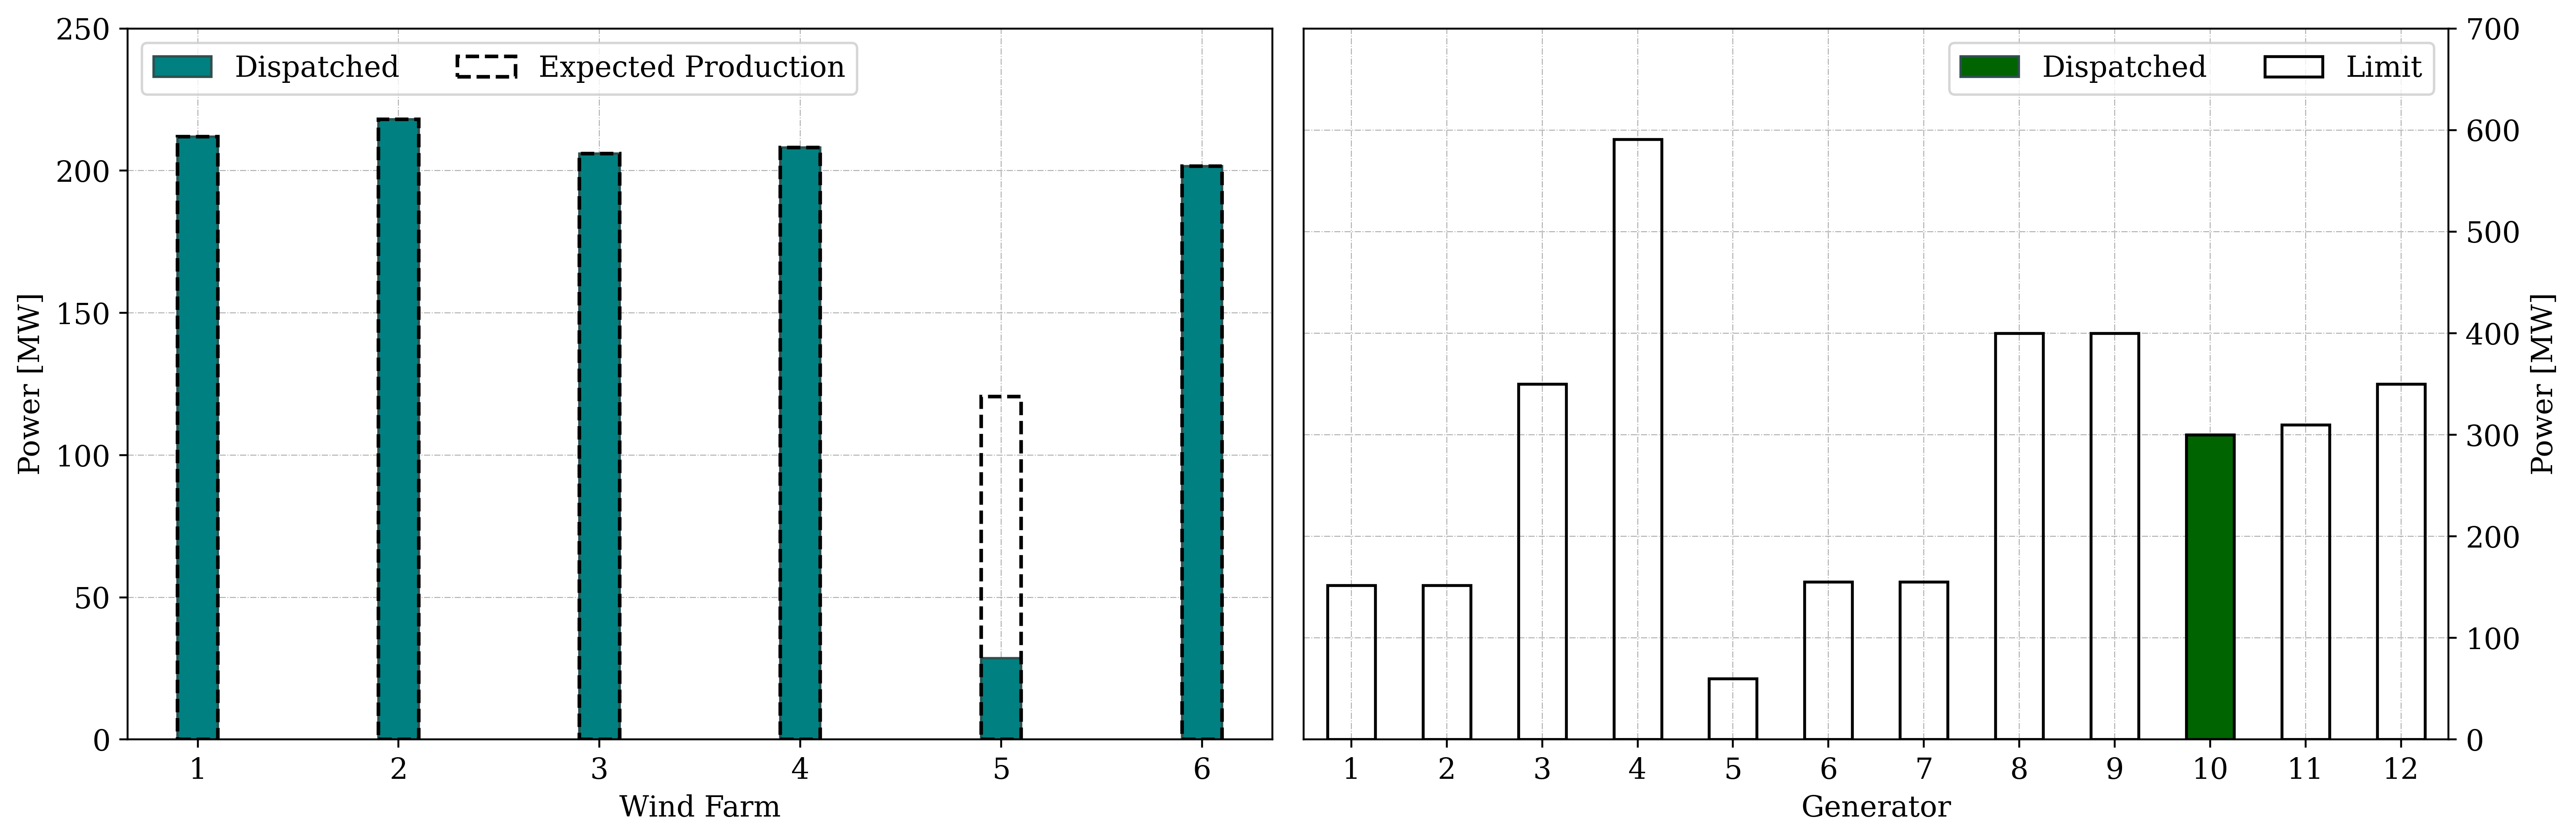

In [54]:
fig, ax = plt.subplots(1,2,sharey=False,figsize=( 15 , 5 ), dpi=400) # Create the figure

wind_data_formatted = wind_data.iloc[t, :].reset_index(drop=True).to_frame().rename(columns={0: 'Expected Production'})

#========== Plot wind farm results ==========
(generator_outputs.loc[generator_outputs.Type == 'Wind','p_G']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched', edgecolor='darkslategrey')
wind_data_formatted.plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, GW), labels = np.arange(1, GW + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)
ax[0].set_ylim([0,250])

#========== Plot conventional generator results ==========
(generator_outputs.loc[generator_outputs.Type == 'Conventional','p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, GC), labels = np.arange(1, GC + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=12)
ax[1].set_ylim([0,700])

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/task_1_results_gen_dispatch.png',bbox_inches='tight')
plt.show()